seed: (258217, 3017545, 4009236, 2652370)
Growing crystal iteration 59/60           
done


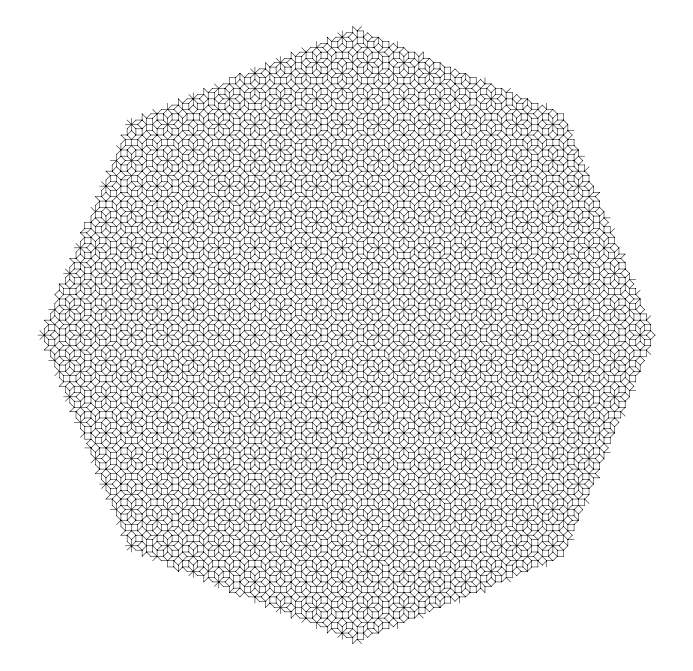

In [2]:
from scipy.spatial.distance import squareform, pdist
from pylab import *
from numpy import * 
from scipy.linalg import null_space
from itertools import product, combinations

N = 4                      # Dimension of crystal
Ndepth = 60                # Iterations to grow crystal
θ = linspace(0,pi,N+1)[1:] # Arrange basis vectors evenly on [0,π)
A = array([cos(θ),sin(θ)]) # Convert from complex notation

# Directions in which to search
D = int32(concatenate([eye(N),-eye(N)])) 

# Matrix to rotate a lattice point π/N in 2D plane
S = zeros((N,N))
S[ -1,0 ] = -1
S[:-1,1:] = eye(N-1)

# Random seed to nucleate crystal
# Set to zero to get a symmetric version
seed = tuple(int32(pinv(A)@(10000000*random.randn(2))))
print('seed:',seed)

# Null space: collapses cutting plane to point at origin
C = null_space(A).T

# All vertices of an N-cube
O = array([*product(*([0,1],)*N)])-0.5

# All vertices of a 2-cube (used to generate N-2 sub-facets)
F = array([*product(*([0,1],)*2)])

# A single corner ("origin" vertex) of an N-2 cube
# plus N-2 vectors defining the other points on the N-2 cube
# Used to test if sub-facet contains the origins
i = [0]+[*2**arange(N-2)]
G = array([*product(*([0,1],)*(N-2))])[i,:]

# All possible pairs of dimension for generating
# all possible N-2 sub-facets of the N-cube
I = [*combinations(range(N),2)]

# Plot
def plotpoints(p):
    u  = pinv(A).T@p
    D  = squareform(pdist(p.T))
    e  = {tuple(sorted(e)) for e in zip(*where(abs(D-1)<1e-6))}
    xy = concatenate([[u[:,a],u[:,b],[NaN,NaN]] for a,b in e])
    plot(*xy.T,lw=0.5,color='k')
    tight_layout()
    axis("equal")
    axis("off")
    
# Generic caching intersection check function
# Map all points to first quadrant and memoize
def cached_crystal_checker(check):
    # Cache results to save time (memoization)
    cache = {}
    def f(q):
        # Convert test point to immutable tuple for cache key
        k = tuple(int32(q)) 
        if not k in cache:
            # Recompute intersection test if not in cache
            # Use symmetry: reduce tests to points in 1st sector
            h = angle([1,1j]@A@q)
            cache[k]=check(q) if 0<=h<=(pi/N*1.1) else f(S@q)
        return cache[k]
    f.__cache__ = cache
    return f
    
@cached_crystal_checker
def check_lp(q):
    return linprog(c=[1,1],A_ub=Aub,
        b_ub=concatenate([.5+q,.5-q]),
        method="revised simplex",
        options={"tol":1e-9}).success

# Given a list of N-cube vertices, construct a list
# of all N-2-cube sub-facets.
subfacets = []
for ij in I:
    # For every pair of directions, and for every 2-cube
    # in each pair of directions... Generate all possible
    # N-2-cube sub-facets.
    v0 = F@eye(N)[ij,:]
    v1 = G@eye(N)[[*{*range(N)}-{*ij}]]
    subfacets.extend(v0[:,None,:]+v1[None,:,:])
vxid = int32(subfacets)@2**arange(N,dtype='i')

# Chec if a sub-facet contains the origin
def subfacet_contains(v):
    p0 = v[0]
    vk = v[1:,:]-p0
    q  = -np.linalg.solve(vk@vk.T,vk@p0)
    return all(q>=0) and all(q<=1)

# Check if N-2 projection of N-cube contains the origin
# (thereby checking for plane-cube intersection)
@cached_crystal_checker
def check_g2(q):
    # Generate list of all N-2 dimensional sub-facets
    # of unit N-cube centered at q
    p  = (q+O).T
    sf = (C@p)[:,vxid].transpose(1,2,0)
    for v in sf:
        if subfacet_contains(v): return True
    return False

# Iteratively check whether adjacent cells on boundary intersect hyperplane
# Add the ones that do to grow the crystal
Q = {seed}
allQ = set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if check_g2(q)} - allQ
    allQ |= Q
    print('\rGrowing crystal iteration %d/%d'%(i,Ndepth),' '*10,end='',flush=True)
print('\ndone')
figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)